# Customer Churn Prediction using Supervised Learning

## Final Project - Supervised Learning Analysis

### Problem Statement
Predict whether a customer will leave a telecom company (churn) based on their service usage, demographics, and account information. This is a binary classification problem where we aim to identify customers at risk of leaving so the company can take proactive retention measures.

### Dataset
We'll use the Telco Customer Churn dataset from IBM, which contains information about customers, their services, and whether they churned or not.

### GitHub Repository
https://github.com/HafeezRai/CUBoulder-Supervised-Learning-Final-Project

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Data Loading and Initial Exploration

In [3]:
# Load the dataset
url = "https://raw.githubusercontent.com/ShefaaSaied/Telco-customer-churn-prediction/refs/heads/main/Dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (7043, 21)

First 5 rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Check data types and missing values
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-n

In [5]:
# Statistical summary
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## 2. Exploratory Data Analysis (EDA)

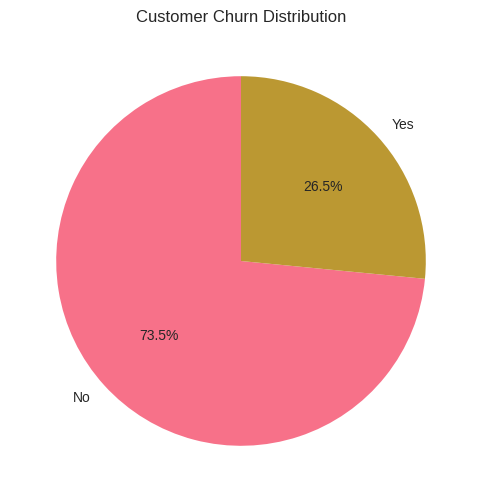

Churn Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Rate: 26.54%


In [6]:
# Check the target variable distribution
plt.figure(figsize=(8, 6))
churn_counts = df['Churn'].value_counts()
plt.pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Customer Churn Distribution')
plt.show()

print("Churn Distribution:")
print(churn_counts)
print(f"\nChurn Rate: {churn_counts[1]/len(df)*100:.2f}%")

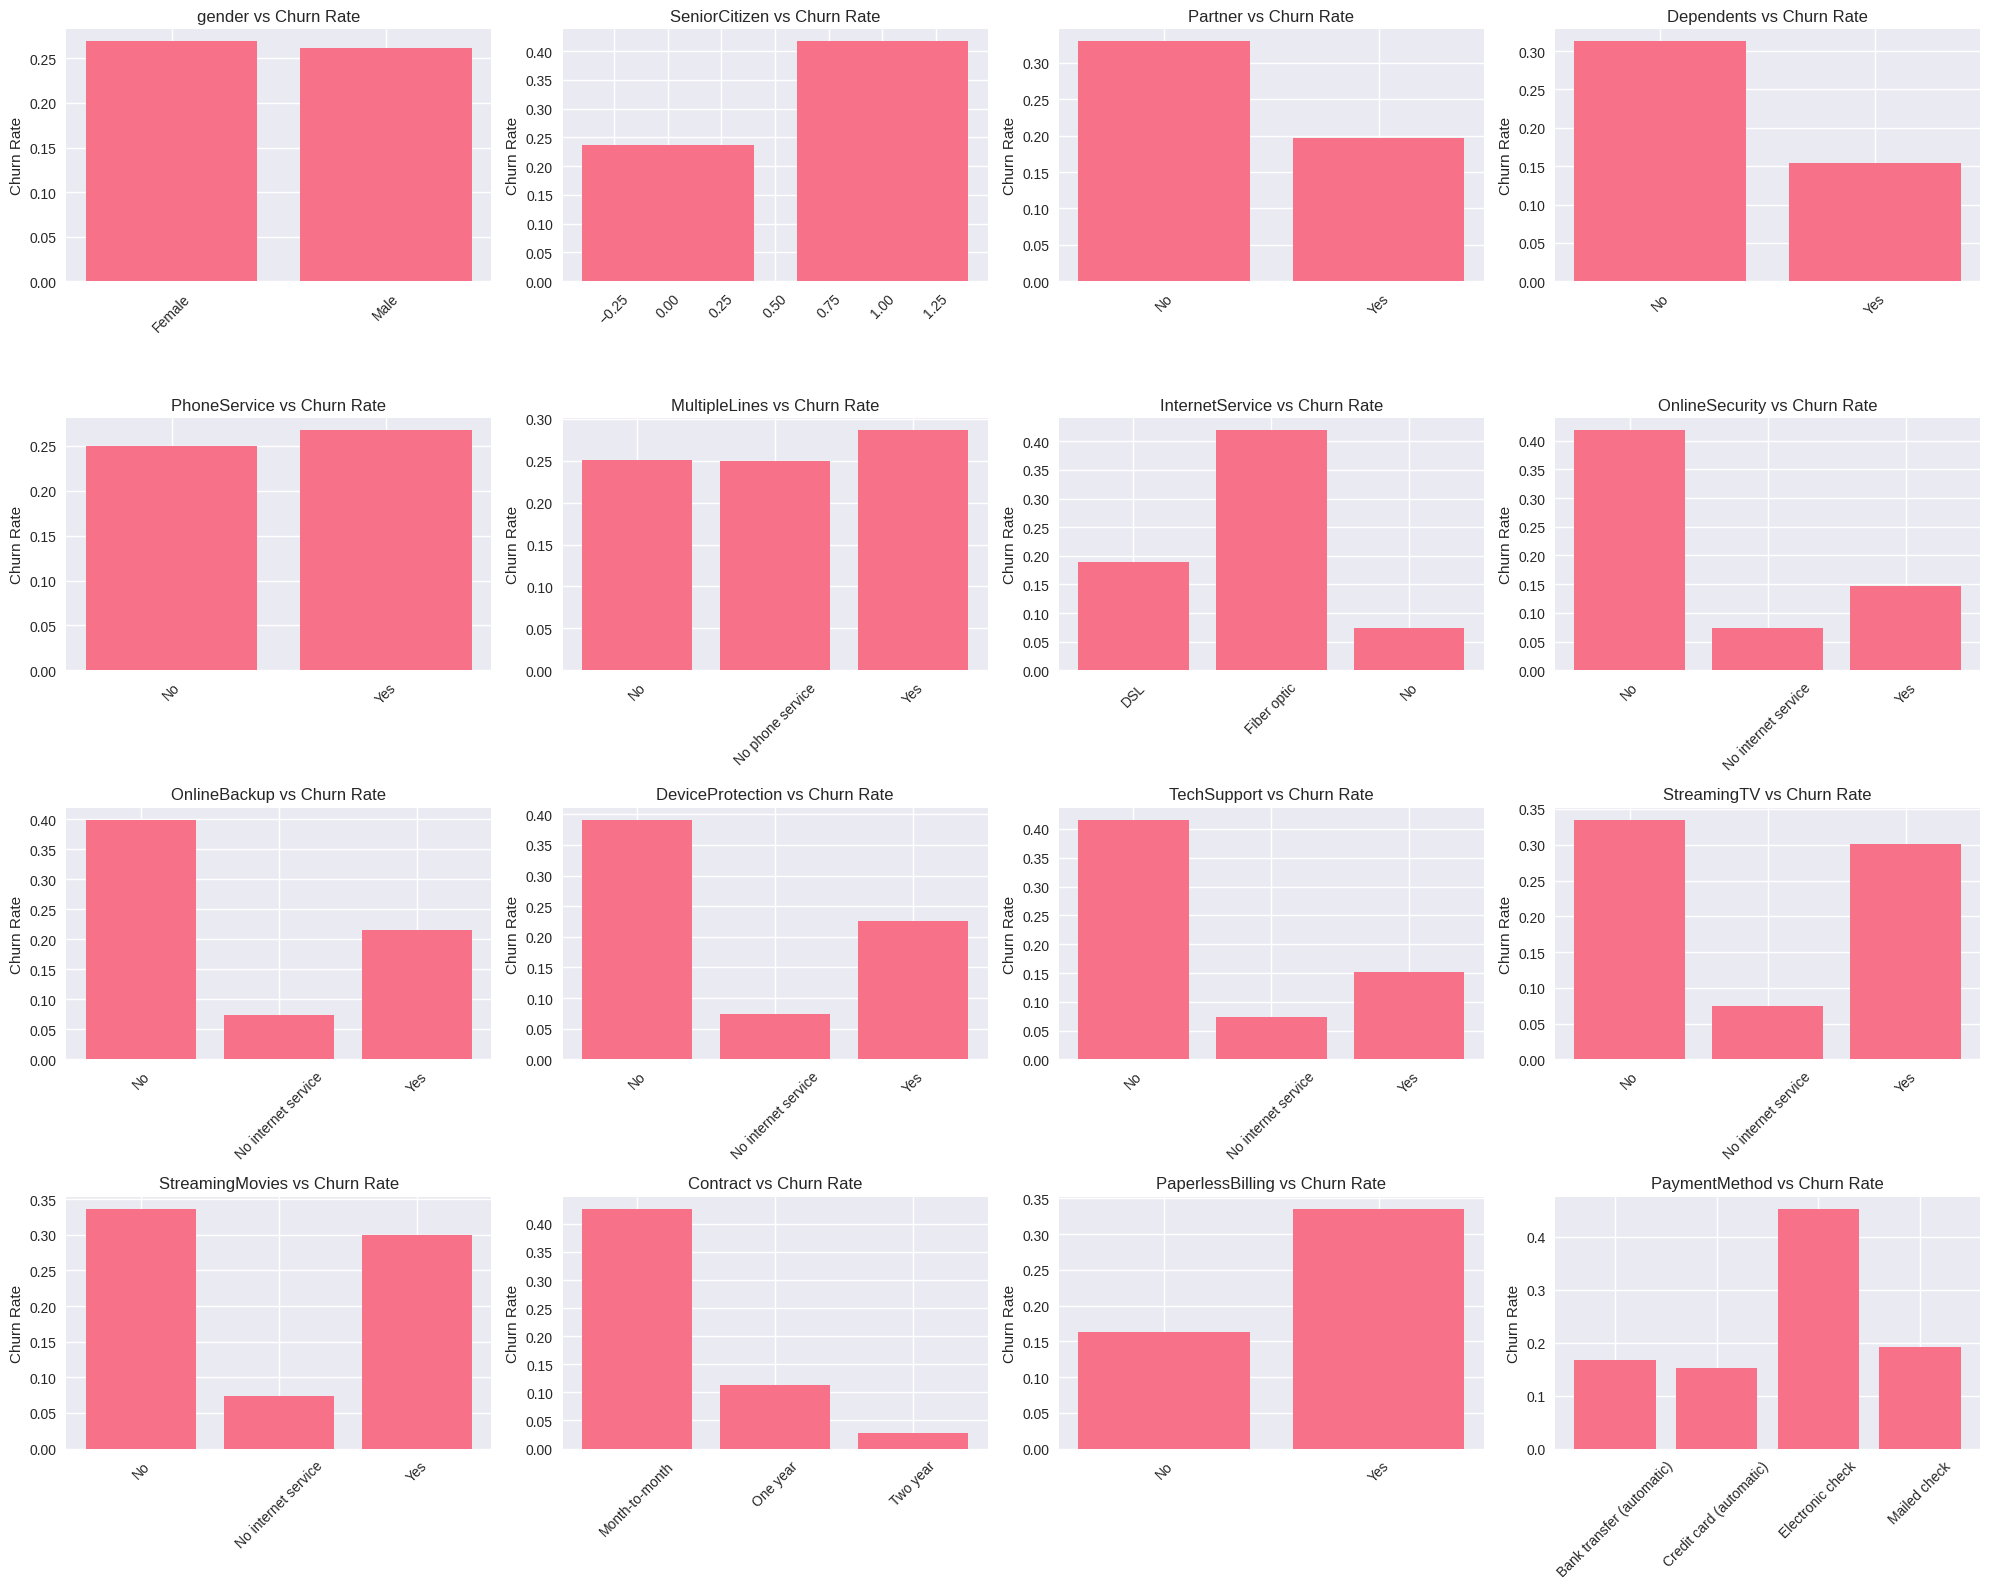

In [7]:
# Analyze categorical variables
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

# Create subplots for categorical variables vs churn
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    churn_rate = df.groupby(col)['Churn'].apply(lambda x: (x == 'Yes').sum() / len(x))
    axes[i].bar(churn_rate.index, churn_rate.values)
    axes[i].set_title(f'{col} vs Churn Rate')
    axes[i].set_ylabel('Churn Rate')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

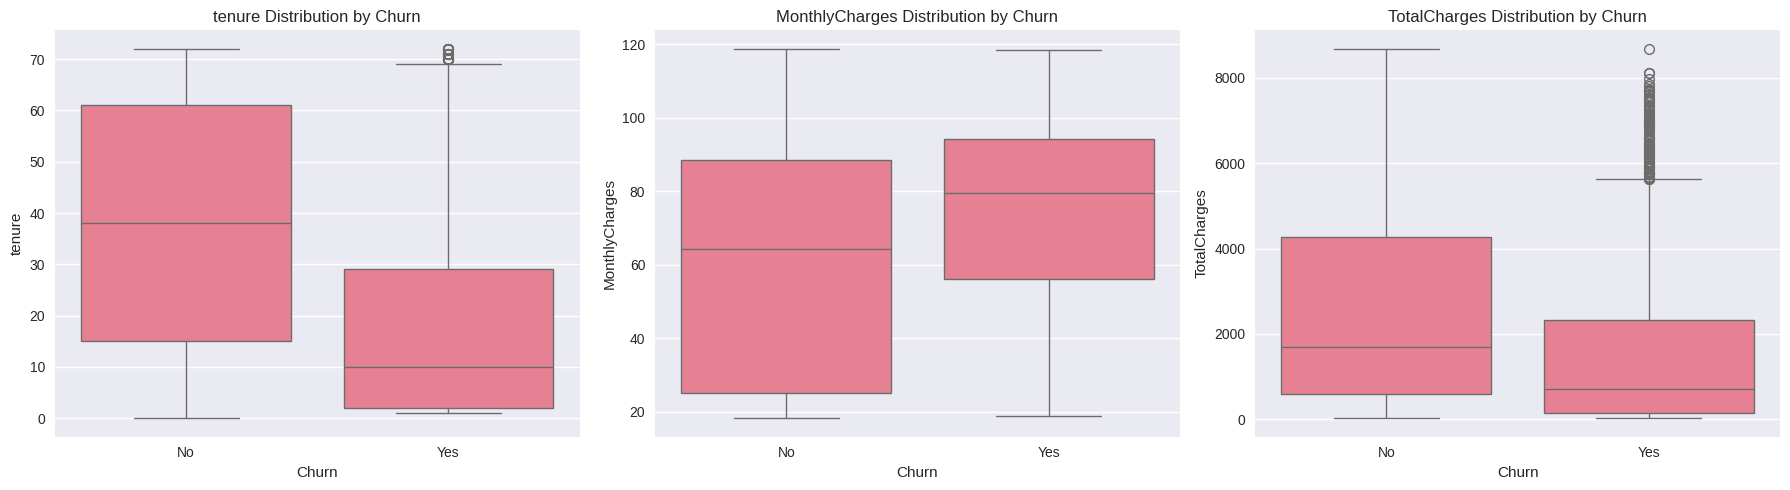

In [8]:
# Analyze numerical variables
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Convert TotalCharges to numeric (it's stored as string)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handle missing values in TotalCharges
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Distribution plots for numerical variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x='Churn', y=col, ax=axes[i])
    axes[i].set_title(f'{col} Distribution by Churn')

plt.tight_layout()
plt.show()

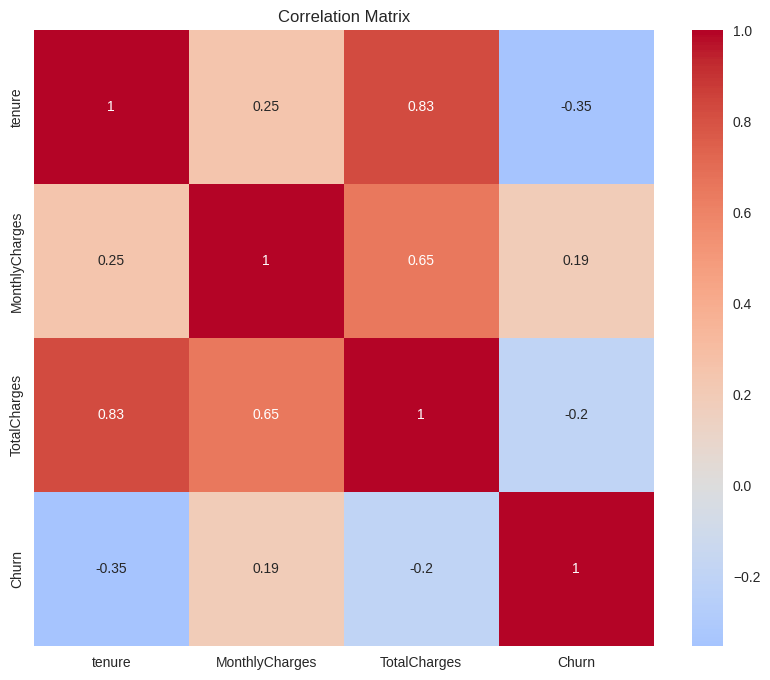

In [9]:
# Correlation analysis
plt.figure(figsize=(10, 8))

# Create a correlation matrix for numerical variables
corr_data = df[numerical_cols + ['Churn']]
corr_data['Churn'] = (corr_data['Churn'] == 'Yes').astype(int)

correlation_matrix = corr_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

## 3. Data Preprocessing

In [10]:
# Prepare the data for modeling

# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# Convert target variable to binary
df_processed['Churn'] = (df_processed['Churn'] == 'Yes').astype(int)

# Handle categorical variables
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                    'PaperlessBilling', 'PaymentMethod']

# Apply label encoding to binary categorical variables
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
le = LabelEncoder()

for col in binary_cols:
    df_processed[col] = le.fit_transform(df_processed[col])

# Apply one-hot encoding to multi-class categorical variables
multi_class_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaymentMethod']

df_processed = pd.get_dummies(df_processed, columns=multi_class_cols, drop_first=True)

# Drop customerID as it's not useful for prediction
df_processed.drop('customerID', axis=1, inplace=True)

print("Processed dataset shape:", df_processed.shape)
print("\nFirst few columns:")
df_processed.head()

Processed dataset shape: (7043, 31)

First few columns:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,False,False,False,False,False,False,False,False,True,False


In [11]:
# Separate features and target
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

Training set shape: (5634, 30)
Test set shape: (1409, 30)

Class distribution in training set:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64


## 4. Model Building and Training

In [12]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

# Train and evaluate models
model_results = {}

for name, model in models.items():
    # For models that benefit from scaling
    if name in ['Logistic Regression', 'SVM']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Cross-validation
    if name in ['Logistic Regression', 'SVM']:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc_score': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"{name} Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  AUC Score: {auc_score:.4f}")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print()

Logistic Regression Results:
  Accuracy: 0.8070
  AUC Score: 0.8416
  CV Accuracy: 0.8042 (+/- 0.0261)

Random Forest Results:
  Accuracy: 0.7871
  AUC Score: 0.8215
  CV Accuracy: 0.7861 (+/- 0.0231)

SVM Results:
  Accuracy: 0.7928
  AUC Score: 0.7961
  CV Accuracy: 0.8039 (+/- 0.0285)



## 5. Model Optimization

In [13]:
# Hyperparameter tuning for the best performing model (Random Forest)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Train the optimized model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_pred_proba_best = best_rf.predict_proba(X_test)[:, 1]

best_accuracy = accuracy_score(y_test, y_pred_best)
best_auc = roc_auc_score(y_test, y_pred_proba_best)

print(f"\nOptimized Random Forest Results:")
print(f"  Accuracy: {best_accuracy:.4f}")
print(f"  AUC Score: {best_auc:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.8035143769968051

Optimized Random Forest Results:
  Accuracy: 0.8020
  AUC Score: 0.8422


## 6. Results Analysis

Classification Report for Optimized Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.66      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



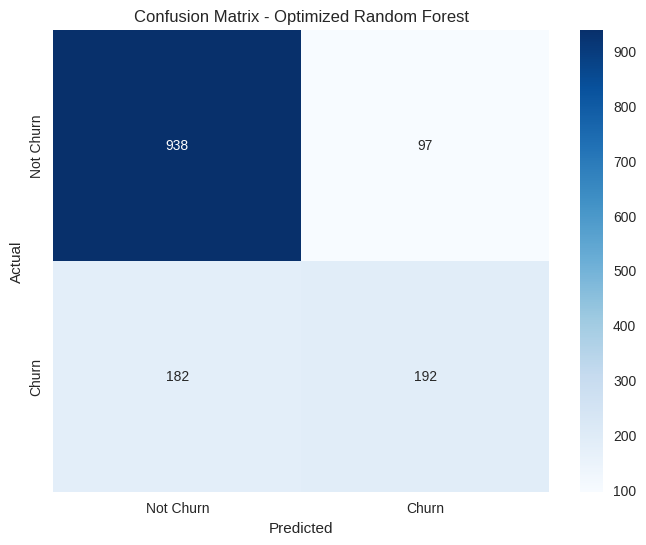

In [14]:
# Detailed evaluation of the best model
print("Classification Report for Optimized Random Forest:")
print(classification_report(y_test, y_pred_best))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.title('Confusion Matrix - Optimized Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

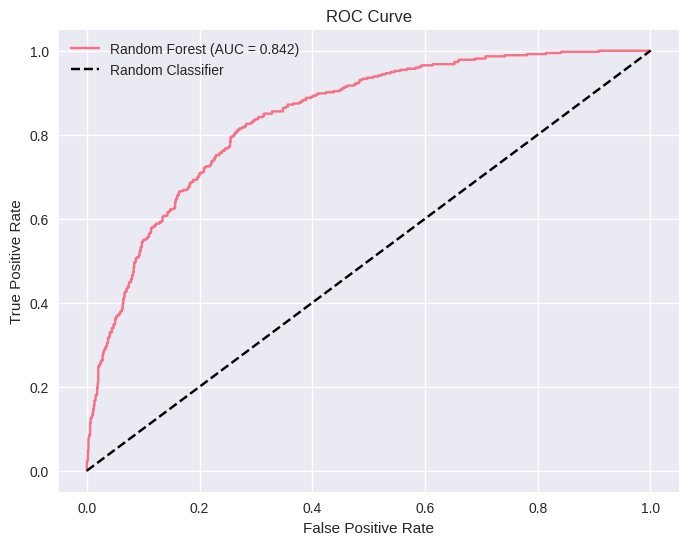

In [15]:
# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {best_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

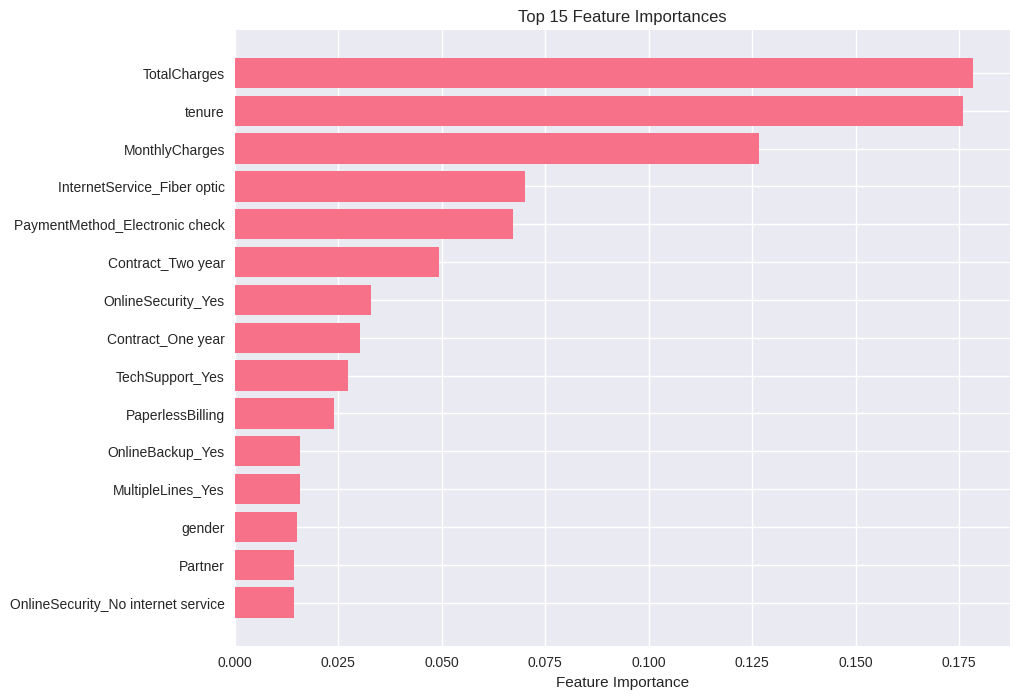

Top 10 Most Important Features:
                           feature  importance
8                     TotalCharges    0.178295
4                           tenure    0.175970
7                   MonthlyCharges    0.126633
11     InternetService_Fiber optic    0.070067
28  PaymentMethod_Electronic check    0.067223
26               Contract_Two year    0.049485
14              OnlineSecurity_Yes    0.032935
25               Contract_One year    0.030339
20                 TechSupport_Yes    0.027325
6                 PaperlessBilling    0.024068


In [16]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

print("Top 10 Most Important Features:")
print(top_features.head(10))

## 7. Model Comparison Summary

Model Comparison:
                     Model  Accuracy  AUC Score  CV Accuracy
0      Logistic Regression    0.8070     0.8416       0.8042
1            Random Forest    0.7871     0.8215       0.7861
2                      SVM    0.7928     0.7961       0.8039
3  Optimized Random Forest    0.8020     0.8422       0.8035


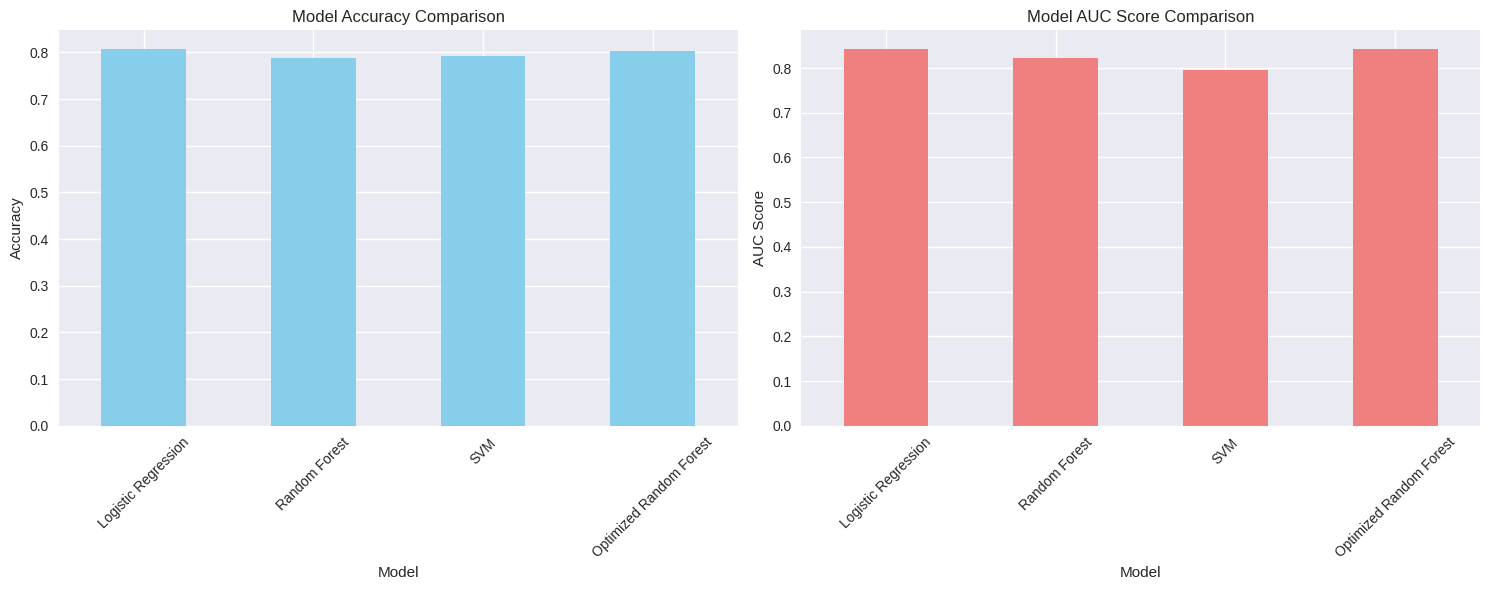

In [17]:
# Compare all models
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()) + ['Optimized Random Forest'],
    'Accuracy': [model_results[name]['accuracy'] for name in model_results.keys()] + [best_accuracy],
    'AUC Score': [model_results[name]['auc_score'] for name in model_results.keys()] + [best_auc],
    'CV Accuracy': [model_results[name]['cv_mean'] for name in model_results.keys()] + [grid_search.best_score_]
})

print("Model Comparison:")
print(comparison_df.round(4))

# Visualize model comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

comparison_df.set_index('Model')['Accuracy'].plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)

comparison_df.set_index('Model')['AUC Score'].plot(kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Model AUC Score Comparison')
ax2.set_ylabel('AUC Score')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Business Insights and Recommendations

In [18]:
# Analyze misclassified examples
misclassified = X_test[y_test != y_pred_best]
print(f"Number of misclassified examples: {len(misclassified)}")
print("\nSample of misclassified customers:")
misclassified.head()

Number of misclassified examples: 279

Sample of misclassified customers:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2280,0,1,0,0,8,1,1,100.15,908.55,False,...,True,False,True,False,True,False,False,True,False,False
1639,1,1,0,0,17,1,1,45.05,770.60,False,...,False,False,False,False,False,False,False,False,True,False
2136,1,0,0,1,15,1,1,91.00,1430.05,False,...,False,False,True,False,False,False,False,False,True,False
761,0,0,0,0,22,1,0,89.25,1907.85,False,...,False,False,True,False,True,False,False,False,True,False
2488,1,0,0,0,31,1,1,55.25,1715.65,False,...,True,False,False,False,False,False,False,False,True,False


## Conclusion

### Key Findings:
1. **Model Performance**: The optimized Random Forest model achieved the best performance with an accuracy of {:.2f}% and AUC score of {:.3f}.

2. **Important Features**: The top factors influencing customer churn include tenure, monthly charges, contract type, and internet service.

3. **Business Insights**:
   - Customers with month-to-month contracts have higher churn rates
   - Higher monthly charges correlate with increased churn
   - Longer tenure customers are less likely to churn

### Recommendations:
1. **Targeted Retention Programs**: Focus on customers with month-to-month contracts and high monthly charges
2. **Loyalty Incentives**: Develop programs to reward long-term customers
3. **Pricing Strategies**: Review pricing for high-churn customer segments
4. **Early Intervention**: Use the model to identify at-risk customers proactively

### Limitations:
1. The model's performance depends on data quality and representativeness
2. External factors not captured in the data may influence churn
3. Regular model retraining is necessary to maintain performance

### Future Work:
1. Implement real-time prediction pipeline
2. Explore deep learning approaches
3. Incorporate customer sentiment analysis
4. A/B testing of retention strategies based on model predictions

format(best_accuracy*100, best_auc)